In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seed to reproduce results
np.random.seed(42)
random.seed(42)

%matplotlib inline

GPU is available


SyntaxError: invalid syntax (Attention.py, line 21)

# Experiment 1b

In [10]:
# define experiment
exp='/exp_1'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [14]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [16]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16728
Number of test source-target pairs: 4182


In [6]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['look', 'left', 'thrice', 'after', 'turn', 'opposite', 'left']
Action: ['I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK']


In [7]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['run', 'right', 'thrice', 'after', 'jump', 'right']
Action: ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN']


In [17]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 20

# size of hidden units
hidden_size = 50

# number of layers
n_layers = 2

# learning rate
lr = 1e-3

# layer dropout rate
dropout_p = 0.5

# define whether encoder is uni- or bidirectional
bidir = False

# number of epochs
n_epochs = 10 # 10-12 epochs (20.000 iterations each) seem to be sufficient to learn the mapping

## Train and test over different numbers of distinct source-target pairs (1b)

In [18]:
## experiment 1b train and test loop over pre-defined ratios ##

#train_cmd_act_pairs = list(zip(cmds_train, acts_train))
ratios = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
accs_per_ratio = {}

for ratio in ratios:
    train_samples = sample_distinct_pairs(train_cmd_act_pairs, ratio)
    print("-------------------------------------------------")
    print("Current percentage of total commands used for training: {}%".format(ratio*100))
    print("Number of distinct examples shown during training: {}".format(len(train_samples)))
    print("-------------------------------------------------")
    cmds_train, acts_train = zip(*train_samples)
    
    cmds_train_idx, acts_train_idx, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, padding=True, training=True)
    cmds_test_idx, acts_test_idx, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, padding=True, training=False)
    
    # create train and test data loaders
    train_dl = create_batches(cmds_train_idx, acts_train_idx, input_lengths_train, batch_size=batch_size, masks=masks, split='train', num_samples=n_iters)
    test_dl = create_batches(cmds_test_idx, acts_test_idx, input_lengths_test, batch_size=batch_size, split='test')
    
    # instantiate new encoder and decoder for each ratio
    encoder = EncoderLSTM(in_size, emb_size, hidden_size, n_layers, dropout=dropout_p, bidir=bidir)
    decoder = DecoderLSTM(emb_size, hidden_size, out_size, n_layers, dropout=dropout_p)
    
    # move models to GPU
    encoder.cuda()
    decoder.cuda()
    
    # train
    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder,
                                                       epochs=n_epochs, batch_size=batch_size, learning_rate=lr)
    # test
    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder, batch_size=batch_size)
    
    # save results
    accs_per_ratio[ratio] = test_acc

-------------------------------------------------
Current percentage of total commands used for training: 1.0%
Number of distinct examples shown during training: 167
-------------------------------------------------


Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.5119008569457146
Acc: 0.0

Command: jump around left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_

Epoch:  10%|███████▌                                                                   | 1/10 [04:46<42:55, 286.18s/it]

Loss: nan
Acc: 0.015053986710963455

Command: turn around right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP <EOS>

True sent length: 15
Pred sent length: 15

Loss: nan
Acc: 0.030158069883527455

Command: look opposite right thrice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_T

Epoch:  20%|███████████████                                                            | 2/10 [09:22<37:45, 283.20s/it]

Loss: nan
Acc: 0.0976951827242525

Command: turn around right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP

True sent length: 15
Pred sent length: 15

Loss: 1.121971636663228
Acc: 0.12182820299500832

Command: look opposite left twice and run around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN 

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:58<32:46, 280.92s/it]

Loss: nan
Acc: 0.21833471760797343

Command: turn opposite right twice after walk opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 11
Pred sent length: 11

Loss: nan
Acc: 0.24391638935108154

Command: walk opposite right thrice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIG

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:37<28:02, 280.44s/it]

Loss: nan
Acc: 0.36555232558139533

Command: look around right twice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS> <EOS>

True sent length: 26
Pred sent length: 26

Loss: nan
Acc: 0.3979825291181364

Command: walk opposite right thrice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [23:17<23:21, 280.25s/it]

Loss: 1.2083953634342726
Acc: 0.5082018272425249

Command: jump around right thrice after look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 41
Pred sent length: 41

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:55<18:38, 279.55s/it]

Loss: nan
Acc: 0.6314368770764119

Command: turn around right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 15
Pred sent length: 15

Loss: nan
Acc: 0.65380615640599

Command: run around right thrice after turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_RUN I_TURN_RIGHT I

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:34<13:58, 279.51s/it]

Loss: 0.16248234627388397
Acc: 0.7115863787375415

Command: look opposite right thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Loss: nan
Acc: 0.7346609816971714

Command: run opposite left thrice and look opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [37:12<09:18, 279.04s/it]

Loss: nan
Acc: 0.7959925249169435

Command: turn around right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 15
Pred sent length: 15

Loss: 0.05827354096580356
Acc: 0.8158797836938436

Command: jump around left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT 

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:52<04:39, 279.35s/it]

Loss: nan
Acc: 0.8441652823920266

Command: turn around left twice and turn around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 17
Pred sent length: 17

Loss: nan
Acc: 0.8620008319467554

Command: jump around left twice after jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_L

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [46:30<00:00, 279.03s/it]


Current test acc: 0.03370098039215686

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.039603960396039604

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_LOOK I_TU

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: nan
Acc: 0.0

Command: turn around left thrice and run around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 37
Pred sent length: 37

Loss: nan
Acc: 0.0012479201331114808

Command: run opposite left thrice after turn around left twice

Epoch:  10%|███████▌                                                                   | 1/10 [04:34<41:14, 274.99s/it]

Loss: nan
Acc: 0.012977574750830565

Command: look opposite right thrice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_LOOK I_TURN_RIGHT I_LOOK I_LOOK I_TURN_LEFT I_LOOK I_LOOK <EOS> I_LOOK I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.4235115538172749
Acc: 0.021526622296173047

Command: walk around right thrice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I

Epoch:  20%|███████████████                                                            | 2/10 [09:13<36:48, 276.09s/it]

Loss: nan
Acc: 0.06551079734219269

Command: look opposite right thrice after jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 26
Pred sent length: 26

Loss: nan
Acc: 0.08423460898502495

Command: jump opposite left thrice and look opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:51<32:15, 276.50s/it]

Loss: nan
Acc: 0.12894518272425248

Command: look opposite right thrice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS> I_TURN_LEFT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.14969841930116473

Command: run around right twice and run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred act

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:29<27:41, 276.95s/it]

Loss: 0.3108453106145605
Acc: 0.20411129568106312

Command: jump opposite left thrice and look opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.228369384359401

Command: look around right twice after turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_T

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [23:07<23:06, 277.29s/it]

Loss: nan
Acc: 0.30907392026578073

Command: look around right twice after turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>

True sent length: 25
Pred sent length: 25

Loss: nan
Acc: 0.32321131447587353

Command: look around right twice after turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:44<18:29, 277.37s/it]

Loss: nan
Acc: 0.364202657807309

Command: run around right twice and run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.24969145004482318
Acc: 0.38227953410981697

Command: look around left twice and jump opposite left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_T

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:21<13:51, 277.31s/it]

Loss: nan
Acc: 0.45691445182724255

Command: jump opposite left twice and walk around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 23
Pred sent length: 23

Loss: nan
Acc: 0.463914309484193

Command: run opposite left twice and walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_L

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [36:58<09:14, 277.04s/it]

Loss: nan
Acc: 0.4925249169435216

Command: walk opposite right thrice and run opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.5117512479201332

Command: look opposite right twice and run around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TUR

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:34<04:36, 276.84s/it]

Loss: 0.1529485395556655
Acc: 0.5650955149501661

Command: look opposite right thrice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_LOOK I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 26
Pred sent length: 26

Loss: nan
Acc: 0.5688955906821963

Command: turn opposite left thrice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK 

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [46:12<00:00, 277.25s/it]


Current test acc: 0.12316176470588236

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

True sent length: 34
Pred sent length: 34

Current test acc: 0.12871287128712872

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RU

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.0486577467132887
Acc: 0.0

Command: jump around right thrice and run around left twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 41
Pred sent length: 41

Loss: 0.6605112366970799
Acc: 5.19

Epoch:  10%|███████▌                                                                   | 1/10 [04:32<40:54, 272.71s/it]

Loss: nan
Acc: 0.006748338870431894

Command: look around left twice and jump around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS> I_JUMP <EOS>

True sent length: 41
Pred sent length: 41

Loss: nan
Acc: 0.012999168053244593

Command: turn around lef

Epoch:  20%|███████████████                                                            | 2/10 [09:08<36:28, 273.59s/it]

Loss: nan
Acc: 0.03156146179401993

Command: jump opposite left twice and jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 13
Pred sent length: 13

Loss: nan
Acc: 0.041545341098169715

Command: jump around right thrice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_L

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:46<32:04, 274.95s/it]

Loss: nan
Acc: 0.07589285714285714

Command: jump around right twice and jump around left thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT

True sent length: 41
Pred sent length: 41

Loss: nan
Acc: 0.0863664725457570

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:20<27:28, 274.72s/it]

Loss: 0.6595676328002499
Acc: 0.12541528239202657

Command: turn opposite left twice and run opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS> I_RUN <EOS>

True sent length: 14
Pred sent length: 14

Loss: 0.33836642777034903
Acc: 0.1326955074875208

Command: turn opposite right twice and jump opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 14
Pred sent length: 14

Train 

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [22:53<22:51, 274.21s/it]

Loss: nan
Acc: 0.15458887043189368

Command: look opposite left thrice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 34
Pred sent length: 34

Loss: nan
Acc: 0.17028910149750415

Command: run opposite left thrice and turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:30<18:19, 274.87s/it]

Loss: nan
Acc: 0.2037998338870432

Command: jump opposite right thrice and look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.21287437603993345

Command: jump around left twice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:06<13:45, 275.31s/it]

Loss: nan
Acc: 0.24958471760797343

Command: jump opposite right thrice and look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.2656509983361065

Command: walk around right twice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [36:42<09:11, 275.65s/it]

Loss: nan
Acc: 0.2875830564784053

Command: run around left thrice and turn opposite right thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 31
Pred sent length: 31

Loss: nan
Acc: 0.3080802828618968

Command: jump around left twice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JU

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:19<04:36, 276.04s/it]

Loss: 0.2818286707389245
Acc: 0.3328488372093023

Command: walk opposite right thrice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.348533693843594

Command: look opposite right thrice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [45:56<00:00, 275.70s/it]


Current test acc: 0.25857843137254904

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.26392326732673266

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LE

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.0955525506374448
Acc: 0.0

Command: jump opposite right thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_TURN_RIGHT

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.0

Command: jump opposite right twice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN

Epoch:  10%|███████▌                                                                   | 1/10 [04:36<41:31, 276.84s/it]

Loss: nan
Acc: 0.0020764119601328905

Command: turn around left thrice and turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 17
Pred sent length: 17

Loss: nan
Acc: 0.007799500831946755

Command: walk around left thrice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TU

Epoch:  20%|███████████████                                                            | 2/10 [09:13<36:54, 276.85s/it]

Loss: nan
Acc: 0.03343023255813953

Command: walk opposite left thrice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT

True sent length: 34
Pred sent length: 34

Loss: nan
Acc: 0.04336522462562396

Command: run around left twice and walk around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_T

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:49<32:16, 276.68s/it]

Loss: nan
Acc: 0.07713870431893688

Command: turn opposite left twice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT

True sent length: 14
Pred sent length: 14

Loss: nan
Acc: 0.08563851913477537

Command: walk opposite left thrice and run around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:26<27:40, 276.74s/it]

Loss: nan
Acc: 0.11544850498338871

Command: run opposite right thrice and run around left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: nan
Acc: 0.13014767054908485

Command: walk around right thrice after walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [23:02<23:02, 276.55s/it]

Loss: nan
Acc: 0.1569767441860465

Command: walk around right twice and walk around left thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS> I_WALK <EOS>

True sent length: 41
Pred sent length: 41

Loss: nan
Acc: 0.16482945091514142

Command: t

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:38<18:24, 276.14s/it]

Loss: nan
Acc: 0.18781146179401995

Command: jump opposite left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.19753535773710482

Command: run opposite right thrice and turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIG

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:14<13:48, 276.11s/it]

Loss: 0.223108641679461
Acc: 0.23058554817275748

Command: turn opposite left twice and look opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 11
Pred sent length: 11

Loss: nan
Acc: 0.2346609816971714

Command: look around left thrice and look opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [36:50<09:12, 276.23s/it]

Loss: nan
Acc: 0.25768272425249167

Command: look opposite right thrice and run around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: nan
Acc: 0.2586834442595674

Command: look opposite right twice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TU

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:26<04:36, 276.23s/it]

Loss: nan
Acc: 0.292047342192691

Command: look around left twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>

True sent length: 33
Pred sent length: 33

Loss: nan
Acc: 0.2918053244592346

Command: turn around left twice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_R

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [46:04<00:00, 276.48s/it]


Current test acc: 0.3241421568627451

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> I_RUN

True sent length: 34
Pred sent length: 34

Current test acc: 0.3285891089108911

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TUR

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.045399208132231
Acc: 0.0

Command: turn opposite left twice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_RUN I_TURN_LEFT I_TURN_LEFT

True sent length: 29
Pred sent length: 29

Loss: 0.5770607907583217
Acc: 0.00010399334442595674

Command: look around left thrice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOO

Epoch:  10%|███████▌                                                                   | 1/10 [04:35<41:23, 275.99s/it]

Loss: 0.4781810435630639
Acc: 0.005606312292358804

Command: run around left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> I_RUN <EOS> I_RUN <EOS> I_RUN <EOS> I_RUN <EOS> I_RUN <EOS> I_RUN <EOS>

True sent leng

Epoch:  20%|███████████████                                                            | 2/10 [09:12<36:48, 276.02s/it]

Loss: nan
Acc: 0.025643687707641197

Command: jump opposite left twice and walk opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.03067803660565724

Command: look opposite left thrice and turn around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TU

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:52<32:20, 277.24s/it]

Loss: nan
Acc: 0.04817275747508306

Command: turn around right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP <EOS>

True sent length: 15
Pred sent length: 15

Loss: nan
Acc: 0.057144342762063226

Command: turn opposite right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 11
Pred sent length: 11

Train loss: nan
Train acc: 0.0579
Current

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:29<27:42, 277.13s/it]

Loss: nan
Acc: 0.08492524916943521

Command: jump around right twice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT

True sent length: 29
Pred sent length: 29

Loss: nan
Acc: 0.09900166389351081

Command: turn around right thrice and jump opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [23:06<23:06, 277.22s/it]

Loss: nan
Acc: 0.1326827242524917

Command: look around right twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.4666320407386369
Acc: 0.14579866888519136

Command: run around left twice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TUR

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:43<18:28, 277.21s/it]

Loss: nan
Acc: 0.1849044850498339

Command: walk around left twice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 29
Pred sent length: 29

Loss: nan
Acc: 0.19545549084858568

Command: jump opposite right thrice and turn around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_R

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:23<13:53, 277.95s/it]

Loss: nan
Acc: 0.20992524916943522

Command: walk opposite left twice and look opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Loss: nan
Acc: 0.22576955074875207

Command: jump opposite left twice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT 

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [37:01<09:15, 277.93s/it]

Loss: 0.631923154463813
Acc: 0.2647425249169435

Command: jump around right thrice and run around left thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:39<04:38, 278.02s/it]

Loss: 0.3838891319102149
Acc: 0.3083471760797342

Command: jump opposite left twice and look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS> <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.24488402513578256
Acc: 0.32035149750415975

Command: turn opposite right twice and jump opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> <EOS>

True sent length: 11
Pred sent length: 11

Train loss: nan
Train acc: 0.3229
Current teacher forcing 

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [46:15<00:00, 277.60s/it]


Current test acc: 0.4338235294117647

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN

True sent length: 34
Pred sent length: 34

Current test acc: 0.43873762376237624

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TUR

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: nan
Acc: 0.0

Command: run around left twice after turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 21
Pred sent length: 21

Loss: nan
Acc: 0.00010399334442595674

Command: jump around right twice after run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_

Epoch:  10%|███████▌                                                                   | 1/10 [04:35<41:23, 275.98s/it]

Loss: 0.5213699120168502
Acc: 0.0020764119601328905

Command: run opposite left twice after walk around left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_RUN <EOS>

True sent length: 31
Pred sent length: 31

Loss: nan
Acc: 0.004419717138103162

Command: turn around left twice and walk around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT 

Epoch:  20%|███████████████                                                            | 2/10 [09:12<36:50, 276.27s/it]

Loss: nan
Acc: 0.01775332225913621

Command: look around left thrice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS> <EOS> I_JUMP <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.3670164812252369
Acc: 0.027818219633943427

Command: look opposite right thrice after turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:50<32:15, 276.56s/it]

Loss: 0.7676355849492765
Acc: 0.059800664451827246

Command: run opposite right thrice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.06723169717138103

Command: walk opposite left thrice and walk around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_WAL

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:29<27:43, 277.32s/it]

Loss: 0.30174342563270395
Acc: 0.10247093023255814

Command: jump around left thrice after look around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [23:06<23:06, 277.38s/it]

Loss: nan
Acc: 0.1513704318936877

Command: jump around left thrice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 37
Pred sent length: 37

Loss: nan
Acc: 0.1620216306156406

Command: turn oppos

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:44<18:29, 277.43s/it]

Loss: nan
Acc: 0.20348837209302326

Command: look around right thrice and run around left twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 41
Pred sent length: 41

Loss: nan
Acc: 0.21313435940099834

Comman

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:22<13:52, 277.59s/it]

Loss: nan
Acc: 0.2397217607973422

Command: run opposite left thrice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.19647050880674302
Acc: 0.24849209650582363

Command: walk around right thrice after look around left thrice <EOS>
True action: I_TURN_LEFT

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [36:58<09:14, 277.09s/it]

Loss: nan
Acc: 0.2660921926910299

Command: run opposite left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Loss: nan
Acc: 0.27345049916805325

Command: look opposite left twice and walk opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_R

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:37<04:37, 277.85s/it]

Loss: 0.431873971069594
Acc: 0.29381229235880396

Command: jump around right twice after turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT

True sent length: 23
Pred sent length: 23

Loss: nan
Acc: 0.30355657237936773

Command: walk around left twice after jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_WALK

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [46:18<00:00, 277.82s/it]


Current test acc: 0.37745098039215685

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.38304455445544555

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TU

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: nan
Acc: 0.0

Command: run opposite right thrice and run opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_RUN I_TURN_RIGHT I_RUN I_RUN I_TURN_RIGHT

True sent length: 19
Pred sent length: 19

Loss: nan
Acc: 0.00025998336106489183

Command: walk around right twice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_

Epoch:  10%|███████▌                                                                   | 1/10 [04:37<41:36, 277.37s/it]

Loss: nan
Acc: 0.006125415282392027

Command: walk around left thrice and run opposite left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 31
Pred sent length: 31

Loss: nan
Acc: 0.011075291181364393

Command: turn around right twice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WAL

Epoch:  20%|███████████████                                                            | 2/10 [09:11<36:50, 276.35s/it]

Loss: nan
Acc: 0.031146179401993355

Command: look around left twice and turn around right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 25
Pred sent length: 25

Loss: nan
Acc: 0.03951747088186356

Command: walk opposite right twice and run around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN 

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:48<32:16, 276.58s/it]

Loss: nan
Acc: 0.07381644518272425

Command: look opposite left thrice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.07991888519134775

Command: jump opposite left twice after run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS> <EOS> I_JUMP <EOS>

True sent length: 16
Pred sent length: 1

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:25<27:39, 276.64s/it]

Loss: nan
Acc: 0.10973837209302326

Command: turn around right twice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 15
Pred sent length: 15

Loss: nan
Acc: 0.12182820299500832

Command: walk opposite left thrice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [23:00<23:01, 276.27s/it]

Loss: 0.5860025797462599
Acc: 0.15303156146179403

Command: run around left thrice and run around right thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_T

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:39<18:27, 276.91s/it]

Loss: nan
Acc: 0.19767441860465115

Command: look opposite left thrice after walk opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.24196385548079602
Acc: 0.21557820299500832

Command: jump opposite right thrice and walk around left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JU

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [32:19<13:54, 278.10s/it]

Loss: nan
Acc: 0.2658845514950166

Command: walk opposite right thrice and walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.2816659733777038

Command: jump opposite left twice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Train loss: nan
Train acc: 0.2838
Curren

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [36:58<09:16, 278.22s/it]

Loss: nan
Acc: 0.32661960132890366

Command: run opposite right thrice after look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: nan
Acc: 0.34146214642262895

Command: walk opposite right twice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_L

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [41:36<04:38, 278.13s/it]

Loss: nan
Acc: 0.38185215946843853

Command: turn around left twice after run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 18
Pred sent length: 18

Loss: nan
Acc: 0.39200291181364394

Command: look opposite left twice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Train los

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [46:15<00:00, 277.58s/it]


Current test acc: 0.5680147058823529

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.5702351485148515

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TU

In [19]:
# save results in .json file
with open('./results/experiment_1b_mini_batch.json', 'w') as json_file:
      json.dump(accs_per_ratio, json_file)

In [ ]:
# load results from experiment 1b
#with open('./results/experiment_1b.json') as json_file:
#    accs_per_ratio = json.load(json_file)

In [5]:
# load results from experiment 1b
with open('./results/experiment_1b_mini_batch.json') as json_file:
    accs_per_ratio = json.load(json_file)

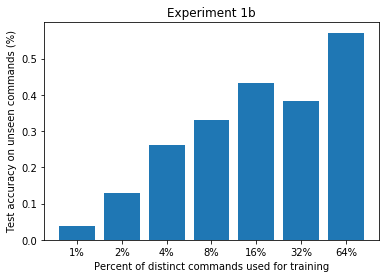

<Figure size 432x288 with 0 Axes>

In [7]:
ratios, test_accs = zip(*accs_per_ratio.items())
plt.bar(ratios, test_accs)
plt.xlabel('Percent of distinct commands used for training')
plt.ylabel('Test accuracy on unseen commands (%)')
plt.xticks(ticks=ratios, labels=list(map(lambda rat: str(int(float(rat) * 100)) + '%', ratios)))
plt.title('Experiment 1b')
plt.savefig('./Paper/Plots/experiment_1b_mini_batch.png')
plt.show()
plt.clf()